In [212]:
pip install gensim

Note: you may need to restart the kernel to use updated packages.


In [270]:
import nltk.stem
import string
import re
import pandas as pd
from nltk.corpus import stopwords
from nltk import word_tokenize, pos_tag
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer, PorterStemmer
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

In [214]:
mainDf = pd.read_csv("justice.csv")
mainDf = mainDf.drop(['Unnamed: 0', 'ID', 'name', 'href', 'docket', 'term', 'first_party',
       'second_party', 'facts_len', 'majority_vote', 'minority_vote', 'decision_type', 'disposition'], axis=1)

In [215]:
mainDf["issue_area"].isna().sum()


142

In [216]:
mainDf = mainDf.dropna(axis=0)

In [217]:
len(mainDf)

3159

In [218]:
mainDf

,facts,first_party_winner,issue_area
1,<p>Joan Stanley had three children with Peter ...,True,Civil Rights
2,<p>John Giglio was convicted of passing forged...,True,Due Process
3,"<p>The Idaho Probate Code specified that ""male...",True,Civil Rights
4,"<p>Miller, after conducting a mass mailing cam...",True,First Amendment
5,<p>Ernest E. Mandel was a Belgian professional...,True,First Amendment
...,...,...,...
3297,<p>For over a century after the Alaska Purchas...,True,Civil Rights
3298,"<p>Refugio Palomar-Santiago, a Mexican nationa...",True,Criminal Procedure
3299,<p>Tarahrick Terry pleaded guilty to one count...,False,Criminal Procedure
3300,<p>Joshua James Cooley was parked in his picku...,True,Civil Rights


In [219]:
mainDf = mainDf.reset_index(drop=True)

In [220]:
mainDf["new_issue_area"] = mainDf['issue_area'].replace({"Due Process": "Others", "Privacy": "Others", "Federal Taxation": "Others", 
                                                     "Unions": "Others", "Federalism": "Others", "Attorneys": "Others",
                                                     "Miscellaneous": "Others", "Interstate Relations": "Others", "Private Action": "Others"})

In [221]:
mainDf

,facts,first_party_winner,issue_area,new_issue_area
0,<p>Joan Stanley had three children with Peter ...,True,Civil Rights,Civil Rights
1,<p>John Giglio was convicted of passing forged...,True,Due Process,Others
2,"<p>The Idaho Probate Code specified that ""male...",True,Civil Rights,Civil Rights
3,"<p>Miller, after conducting a mass mailing cam...",True,First Amendment,First Amendment
4,<p>Ernest E. Mandel was a Belgian professional...,True,First Amendment,First Amendment
...,...,...,...,...
3154,<p>For over a century after the Alaska Purchas...,True,Civil Rights,Civil Rights
3155,"<p>Refugio Palomar-Santiago, a Mexican nationa...",True,Criminal Procedure,Criminal Procedure
3156,<p>Tarahrick Terry pleaded guilty to one count...,False,Criminal Procedure,Criminal Procedure
3157,<p>Joshua James Cooley was parked in his picku...,True,Civil Rights,Civil Rights


# Analysis of the data

Before starting changing anything on the dataset, we check the number of data for each prediction outcome.

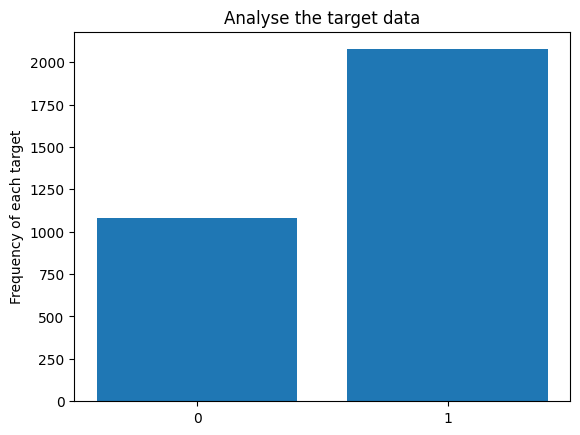

In [222]:
freqTarget = mainDf.groupby(["first_party_winner"], as_index=False, sort=True)["facts"].count()
plt.bar(freqTarget["first_party_winner"], freqTarget["facts"])
plt.xticks(freqTarget["first_party_winner"])
plt.title("Analyse the target data")
plt.ylabel('Frequency of each target')
plt.show()

Also the issue area is important to analyse to see if we can combine some categories. We noticed a very large difference in number between each issue_area category, hence we decided to combine the small categories into "Others".

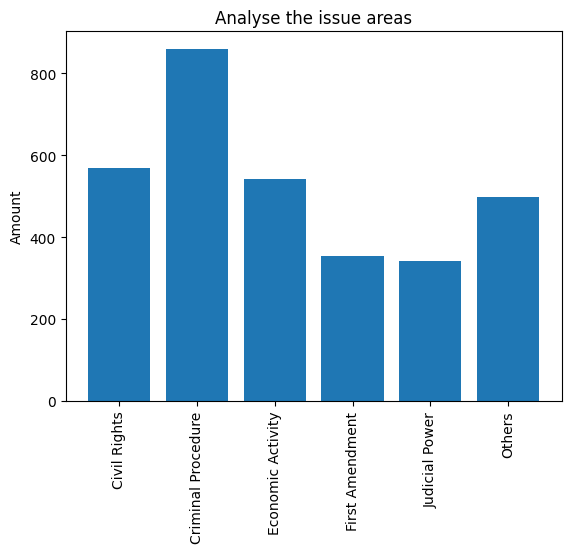

In [223]:
freqTarget = mainDf.groupby(["new_issue_area"], as_index=False, sort=True)["facts"].count()

plt.bar(freqTarget["new_issue_area"], freqTarget["facts"])
plt.xticks(freqTarget["new_issue_area"])
plt.title("Analyse the issue areas")
plt.xticks(rotation=90)
plt.ylabel('Amount')
plt.show()

In [224]:
documents = []
X = mainDf["facts"]
pattern = r'[' + string.punctuation + ']'

for i in range(0, len(X)):
  document = sample_str = re.sub(pattern, " ", str(X[i]))
  document = re.sub(r"\W", " ", document)
  document = re.sub(r"\d+", " ", document)
  document = re.sub(r'\b\w{1,1}\b', " ", document)
  document = re.sub(" \d+", " ", document)
  document = re.sub(r"\s+", " ", document, flags=re.I)
  document = document.lower()
  documents.append(document)

In [225]:
tokenDocuments = []
for i in range(0, len(X)):
    tokenDocuments.append(word_tokenize(documents[i]))

In [226]:
stop_words = stopwords.words("english")

In [227]:
cleanTokenDocuments = []

for i in range(0, len(X)):
    cleanTokenDocument = []
    for word in tokenDocuments[i]:
        if word not in stop_words:
            cleanTokenDocument.append(word)
    cleanTokenDocuments.append(cleanTokenDocument)
mainDf["facts"] = cleanTokenDocuments

In [228]:
lemma = WordNetLemmatizer()

mainDf["lemma"] = mainDf["facts"].apply(lambda x: [lemma.lemmatize(y) for y in x])

In [229]:
postagDocuments = []
for sen in mainDf["lemma"]:
    postagDocuments.append(pos_tag(sen))

mainDf["lemmaPos"] = postagDocuments

In [230]:
words_set = set()
 
for doc in mainDf["facts"]:
    for word in doc:
        if word not in words_set:
            words_set.add(word)
     
print('Number of words in the corpus:',len(words_set))

Number of words in the corpus: 18561


In [231]:
lemmaWithSomePostagDocuments = []
for sen in mainDf["lemmaPos"]:
    lemmaWithSomePostagDocument = []
    for w in sen:
        if w[1] != "UH" and w[1] != "WP" and w[1] != "WP$" and w[1] != "WRB" and w[1] != "PRP" and w[1] != "PRP$" and w[1] != "MD" and w[1] != "WDT":
            lemmaWithSomePostagDocument.append(w[0])
    lemmaWithSomePostagDocuments.append(lemmaWithSomePostagDocument)
            
mainDf["lemma"] = lemmaWithSomePostagDocuments

In [232]:
words_set = set()
 
for doc in mainDf["lemma"]:
    for word in doc:
        if word not in words_set:
            words_set.add(word)
     
print('Number of words in the corpus:',len(words_set))

Number of words in the corpus: 16648


In [233]:
words = []
freqOfWords = []

for doc in mainDf["lemma"]:
    for word in doc:
        if word not in words:
            words.append(word)
            freqOfWords.append(1)
        else:
            idx = words.index(word)
            freqOfWords[idx] = freqOfWords[idx] + 1

In [234]:
d = {'words': words, 'frequency': freqOfWords}
freqWordDf = pd.DataFrame(data=d)
freqWordDf = freqWordDf.sort_values(by=['frequency'])

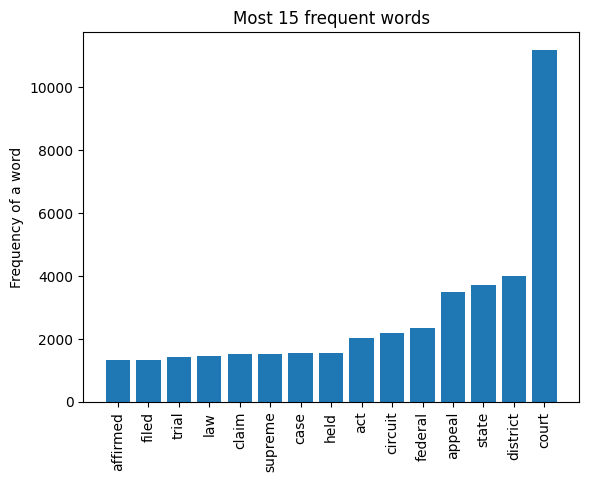

In [235]:
plt.bar(freqWordDf.tail(15)["words"], freqWordDf.tail(15)["frequency"])
plt.xticks(freqWordDf.tail(15)["words"])
plt.title("Most 15 frequent words")
plt.ylabel('Frequency of a word')
plt.xticks(rotation = 90) 
plt.show()

In [236]:
words = []
targetVar = []
onesList = []
for row in range(0, len(mainDf["lemma"])):
    for word in mainDf["lemma"][row]:
        words.append(word)
        targetVar.append(mainDf["first_party_winner"][row]) 
        onesList.append(1)

In [237]:
d = {'words': words, 'first_party_winner': targetVar, "listOfOnes": onesList}
freqDf = pd.DataFrame(data=d)

In [238]:
countFreqDf = freqDf.groupby(["first_party_winner", "words"], as_index=False, sort=True)["listOfOnes"].count()

In [239]:
countFreqDfZeros = countFreqDf[countFreqDf['first_party_winner'].isin([0])].sort_values(by=['listOfOnes'])
countFreqDfZeros[countFreqDfZeros["listOfOnes"].isin([1])].count()

first_party_winner    3324
words                 3324
listOfOnes            3324
dtype: int64

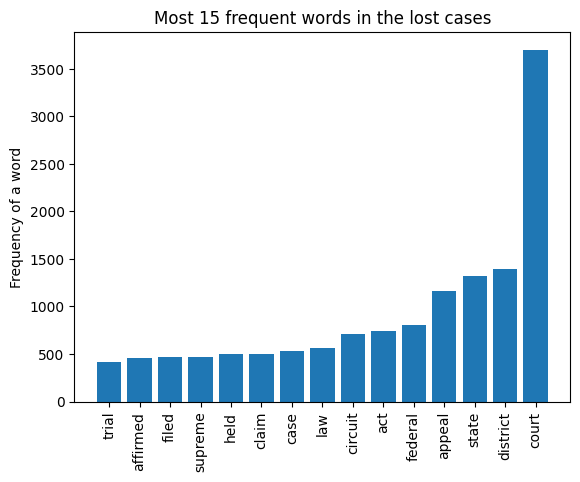

In [240]:
plt.bar(countFreqDfZeros.tail(15)["words"], countFreqDfZeros.tail(15)["listOfOnes"])
plt.xticks(countFreqDfZeros.tail(15)["words"])
plt.title("Most 15 frequent words in the lost cases")
plt.ylabel('Frequency of a word')
plt.xticks(rotation = 90) 
plt.show()

In [241]:
countFreqDfOnes = countFreqDf[countFreqDf['first_party_winner'].isin([1])].sort_values(by=['listOfOnes'])
countFreqDfOnes[countFreqDfOnes["listOfOnes"].isin([1])].count()

first_party_winner    4302
words                 4302
listOfOnes            4302
dtype: int64

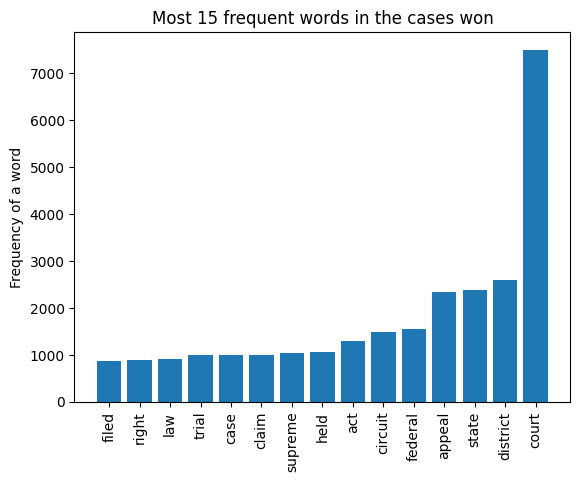

In [242]:
plt.bar(countFreqDfOnes.tail(15)["words"], countFreqDfOnes.tail(15)["listOfOnes"])
plt.xticks(countFreqDfOnes.tail(15)["words"])
plt.title("Most 15 frequent words in the cases won")
plt.ylabel('Frequency of a word')
plt.xticks(rotation = 90) 
plt.show()

In [243]:
from gensim.models import Word2Vec

In [244]:
model = Word2Vec(sentences=mainDf["lemma"], vector_size=100, window=5, min_count=1, workers=4)
model.save("word2vec.model")

In [245]:
model = Word2Vec.load("word2vec.model")

In [246]:
vecDim = []

for i in range(0, len(mainDf)):
    wordToNumber = []
    for wordToVec in mainDf["lemma"][i]:
        wordToNumber.append(model.wv['court'])
    vecDim.append(wordToNumber)
vecDimDf = pd.DataFrame({"vec": vecDim})

In [247]:
maxLengthOfVec = 0
for i in range(0, len(vecDim)):
    if len(vecDim[i]) > maxLengthOfVec:
        maxLengthOfVec = len(vecDim[i])

In [248]:
maxLengthOfVec

531

In [249]:
mainDf = pd.merge(mainDf, vecDimDf, left_index=True, right_index=True)

In [256]:
mainDf["label_issue_area"] = mainDf['new_issue_area'].replace({'Civil Rights': 1, 'Others': 2, 
                                                                'First Amendment': 3, 'Criminal Procedure': 4,
                                                               'Economic Activity': 5, 'Judicial Power': 6})

In [257]:
mainDf

,facts,first_party_winner,issue_area,new_issue_area,lemma,lemmaPos,vec,vec_mean,label_issue_area
0,"[joan, stanley, three, children, peter, stanle...",True,Civil Rights,Civil Rights,"[joan, stanley, three, child, peter, stanley, ...","[(joan, NN), (stanley, VBD), (three, CD), (chi...","[[-0.5843567, 2.279764, 0.53048813, 0.05563838...","[2.97191162109375, 1.938203125, 1.421348876953...",1
1,"[john, giglio, convicted, passing, forged, mon...",True,Due Process,Others,"[john, giglio, convicted, passing, forged, mon...","[(john, NN), (giglio, NN), (convicted, VBD), (...","[[-0.5843567, 2.279764, 0.53048813, 0.05563838...","[2.97191162109375, 1.938203125, 1.421348876953...",2
2,"[idaho, probate, code, specified, males, must,...",True,Civil Rights,Civil Rights,"[idaho, probate, code, specified, male, prefer...","[(idaho, JJ), (probate, NN), (code, NN), (spec...","[[-0.5843567, 2.279764, 0.53048813, 0.05563838...","[2.97191162109375, 1.938203125, 1.421348876953...",1
3,"[miller, conducting, mass, mailing, campaign, ...",True,First Amendment,First Amendment,"[miller, conducting, mass, mailing, campaign, ...","[(miller, NN), (conducting, VBG), (mass, NN), ...","[[-0.5843567, 2.279764, 0.53048813, 0.05563838...","[2.97191162109375, 1.938203125, 1.421348876953...",3
4,"[ernest, mandel, belgian, professional, journa...",True,First Amendment,First Amendment,"[ernest, mandel, belgian, professional, journa...","[(ernest, JJS), (mandel, NN), (belgian, JJ), (...","[[-0.5843567, 2.279764, 0.53048813, 0.05563838...","[2.97191162109375, 1.938203125, 1.421348876953...",3
...,...,...,...,...,...,...,...,...,...
3154,"[century, alaska, purchase, federal, governmen...",True,Civil Rights,Civil Rights,"[century, alaska, purchase, federal, governmen...","[(century, NN), (alaska, JJ), (purchase, NN), ...","[[-0.5843567, 2.279764, 0.53048813, 0.05563838...","[2.97191162109375, 1.938203125, 1.421348876953...",1
3155,"[refugio, palomar, santiago, mexican, national...",True,Criminal Procedure,Criminal Procedure,"[refugio, palomar, santiago, mexican, national...","[(refugio, NN), (palomar, NN), (santiago, JJ),...","[[-0.5843567, 2.279764, 0.53048813, 0.05563838...","[2.97191162109375, 1.938203125, 1.421348876953...",4
3156,"[tarahrick, terry, pleaded, guilty, one, count...",False,Criminal Procedure,Criminal Procedure,"[tarahrick, terry, pleaded, guilty, one, count...","[(tarahrick, NN), (terry, NN), (pleaded, VBD),...","[[-0.5843567, 2.279764, 0.53048813, 0.05563838...","[2.97191162109375, 1.938203125, 1.421348876953...",4
3157,"[joshua, james, cooley, parked, pickup, truck,...",True,Civil Rights,Civil Rights,"[joshua, james, cooley, parked, pickup, truck,...","[(joshua, NN), (james, NNS), (cooley, VBP), (p...","[[-0.5843567, 2.279764, 0.53048813, 0.05563838...","[2.97191162109375, 1.938203125, 1.421348876953...",1


------------------------------------------------------
------------------------------------------------------

DO NOT RUN IT!!

In [196]:
padVec = np.zeros(100)

In [198]:
for i in range(0, len(mainDf)):
    while len(mainDf["vec"][i]) < maxLengthOfVec:
        mainDf["vec"][i].append(padVec)

------------------------------------------------
------------------------------------------------

In [251]:
mainDf

,facts,first_party_winner,issue_area,new_issue_area,lemma,lemmaPos,vec
0,"[joan, stanley, three, children, peter, stanle...",True,Civil Rights,Civil Rights,"[joan, stanley, three, child, peter, stanley, ...","[(joan, NN), (stanley, VBD), (three, CD), (chi...","[[-0.5843567, 2.279764, 0.53048813, 0.05563838..."
1,"[john, giglio, convicted, passing, forged, mon...",True,Due Process,Others,"[john, giglio, convicted, passing, forged, mon...","[(john, NN), (giglio, NN), (convicted, VBD), (...","[[-0.5843567, 2.279764, 0.53048813, 0.05563838..."
2,"[idaho, probate, code, specified, males, must,...",True,Civil Rights,Civil Rights,"[idaho, probate, code, specified, male, prefer...","[(idaho, JJ), (probate, NN), (code, NN), (spec...","[[-0.5843567, 2.279764, 0.53048813, 0.05563838..."
3,"[miller, conducting, mass, mailing, campaign, ...",True,First Amendment,First Amendment,"[miller, conducting, mass, mailing, campaign, ...","[(miller, NN), (conducting, VBG), (mass, NN), ...","[[-0.5843567, 2.279764, 0.53048813, 0.05563838..."
4,"[ernest, mandel, belgian, professional, journa...",True,First Amendment,First Amendment,"[ernest, mandel, belgian, professional, journa...","[(ernest, JJS), (mandel, NN), (belgian, JJ), (...","[[-0.5843567, 2.279764, 0.53048813, 0.05563838..."
...,...,...,...,...,...,...,...
3154,"[century, alaska, purchase, federal, governmen...",True,Civil Rights,Civil Rights,"[century, alaska, purchase, federal, governmen...","[(century, NN), (alaska, JJ), (purchase, NN), ...","[[-0.5843567, 2.279764, 0.53048813, 0.05563838..."
3155,"[refugio, palomar, santiago, mexican, national...",True,Criminal Procedure,Criminal Procedure,"[refugio, palomar, santiago, mexican, national...","[(refugio, NN), (palomar, NN), (santiago, JJ),...","[[-0.5843567, 2.279764, 0.53048813, 0.05563838..."
3156,"[tarahrick, terry, pleaded, guilty, one, count...",False,Criminal Procedure,Criminal Procedure,"[tarahrick, terry, pleaded, guilty, one, count...","[(tarahrick, NN), (terry, NN), (pleaded, VBD),...","[[-0.5843567, 2.279764, 0.53048813, 0.05563838..."
3157,"[joshua, james, cooley, parked, pickup, truck,...",True,Civil Rights,Civil Rights,"[joshua, james, cooley, parked, pickup, truck,...","[(joshua, NN), (james, NNS), (cooley, VBP), (p...","[[-0.5843567, 2.279764, 0.53048813, 0.05563838..."


In [252]:
vec_mean_vec = []
for i in range(0, len(mainDf)):
    vec_mean = []
    for j in range(0, len(mainDf["vec"])):
        feature_vec = np.sum(mainDf["vec"][j])
        vec_mean.append(feature_vec/100)
    vec_mean_vec.append(vec_mean)
vecDimDf = pd.DataFrame({"vec_mean": vec_mean_vec})

In [253]:
mainDf = pd.merge(mainDf, vecDimDf, left_index=True, right_index=True)

In [258]:
X = mainDf["vec_mean"]
y = mainDf["label_issue_area"]

In [259]:
X_array = np.array(X)
y_array = np.array(y)

In [260]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)

In [266]:
X_train = np.vstack(X_train)

In [267]:
X_train.shape, y_train.shape

((2527, 3159), (2527,))

In [ ]:
y_train[]

In [268]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators = 1000, random_state = 42)
rf.fit(X_train, y_train);

In [269]:
result = rf.predict(X_train)

In [273]:
result.shape, y_test.shape

((2527,), (632,))

In [274]:
print(classification_report(y_train, result))

              precision    recall  f1-score   support

           1       0.00      0.00      0.00       460
           2       0.00      0.00      0.00       396
           3       0.00      0.00      0.00       282
           4       0.27      1.00      0.43       686
           5       0.00      0.00      0.00       443
           6       0.00      0.00      0.00       260

    accuracy                           0.27      2527
   macro avg       0.05      0.17      0.07      2527
weighted avg       0.07      0.27      0.12      2527



/Users/carolina/Documents/Semester_9/Natural_Language_Processing/SupremeCourtJudgementPrediction/my_envnlp/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/carolina/Documents/Semester_9/Natural_Language_Processing/SupremeCourtJudgementPrediction/my_envnlp/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/carolina/Documents/Semester_9/Natural_Language_Processing/SupremeCourtJudgementPrediction/my_envnlp/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedM